In [1]:
#Install required libraries

import pandas as pd
from sklearn.impute import SimpleImputer
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder

**DATA COLLECTION**

In [2]:
# Load the data
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')

# Merge datasets to get complete information
order_products = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products = pd.merge(order_products, aisles, on='aisle_id', how='left')

# Display the first few rows
print(order_products.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id               aisle  
0        86             16                eggs  
1        83              4    fresh vegetables  
2       104             13   spices seasonings  
3        19             13       oils vinegars  
4        17             13  baking ingredients  


**ENHANCED DATA CLEANING PROCESS**

In [3]:

# Check for missing values
print(order_products.isnull().sum())

# If there are any missing values in numerical columns, fill them (currently, there are none in 'add_to_cart_order')
imputer_numeric = SimpleImputer(strategy='mean')
order_products['add_to_cart_order'] = imputer_numeric.fit_transform(order_products[['add_to_cart_order']])

# Remove duplicates
order_products = order_products.drop_duplicates()

# Normalize the 'add_to_cart_order' column if needed
order_products['add_to_cart_order'] = (order_products['add_to_cart_order'] - order_products['add_to_cart_order'].mean()) / order_products['add_to_cart_order'].std()

print("Data after cleaning:")
print(order_products.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


order_id             0
product_id           0
add_to_cart_order    0
reordered            0
product_name         0
aisle_id             0
department_id        0
aisle                0
dtype: int64
Data after cleaning:
   order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120          -1.031488          1     Organic Egg Whites   
1         2       28985          -0.891170          1  Michigan Organic Kale   
2         2        9327          -0.750852          0          Garlic Powder   
3         2       45918          -0.610534          1         Coconut Butter   
4         2       30035          -0.470216          0      Natural Sweetener   

   aisle_id  department_id               aisle  
0        86             16                eggs  
1        83              4    fresh vegetables  
2       104             13   spices seasonings  
3        19             13       oils vinegars  
4        17             13  baking ingredients  


**PRODUCT PERFORMANCE ANALYSIS**

In [4]:
# Group by product and aggregate sales and reorder rate
product_performance = order_products.groupby('product_id').agg({
    'reordered': 'sum',
    'add_to_cart_order': 'mean'
}).reset_index()

# Merge with product details
product_performance = pd.merge(product_performance, products[['product_id', 'product_name']], on='product_id', how='left')

# Sort by reordered count
top_products = product_performance.sort_values(by='reordered', ascending=False).head(10)

print("Top Performing Products:")
print(top_products[['product_name', 'reordered', 'add_to_cart_order']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top Performing Products:
                 product_name  reordered  add_to_cart_order
24848                  Banana     398609          -0.485072
13172  Bag of Organic Bananas     315913          -0.456753
21133    Organic Strawberries     205845          -0.154655
21899    Organic Baby Spinach     186884          -0.129294
47198    Organic Hass Avocado     170131          -0.221150
47755         Organic Avocado     134044          -0.267510
27839      Organic Whole Milk     114510          -0.409213
47615             Large Lemon     106255          -0.056472
27960     Organic Raspberries     105409          -0.159547
16793            Strawberries      99802          -0.173290


**PRODUCT AFFINITY AND COMPLEMENTARY ITEM ANALYSIS**

In [5]:
#Take a small sample of the dataset for memory management
order_products_subset = order_products.sample(frac=0.5)

#Prepare data for apriori using TransactionEncoder
order_product_list = order_products_subset.groupby('order_id')['product_name'].apply(list)

#Convert transactions into a list of lists
te = TransactionEncoder()
te_ary = te.fit_transform(order_product_list)
order_product_df = pd.DataFrame(te_ary, columns=te.columns_)

#Apply the Apriori algorithm with a lower min_support value
frequent_itemsets = apriori(order_product_df, min_support=0.01, use_colnames=True)

#Generate the association rules with a lower min_threshold for lift
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)

#Display top product pairings
top_rules = rules.sort_values(by='lift', ascending=False).head(10)
print("Top Product Pairings:")
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top Product Pairings:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


**TARGETED RECOMMENDATIONS AND MARKETING STRATEGIES**

In [6]:
# Define thresholds for high performance products
high_reorder_threshold = product_performance['reordered'].quantile(0.75)

# Filter high performing products
high_performance_products = product_performance[product_performance['reordered'] > high_reorder_threshold]

# Suggest targeted marketing strategies
print("Suggested Marketing Strategies:")
print("- Focus on high reorder rate products for loyalty programs.")
print("- Bundle complementary products identified in affinity analysis for upselling.")
print("- Create personalized recommendations based on customer purchase history.")

# Recommend products based on product affinity analysis
recommended_products = high_performance_products[['product_name']].head(5)
print("Recommended Products for Upselling:")
print(recommended_products)

Suggested Marketing Strategies:
- Focus on high reorder rate products for loyalty programs.
- Bundle complementary products identified in affinity analysis for upselling.
- Create personalized recommendations based on customer purchase history.
Recommended Products for Upselling:
                                         product_name
0                          Chocolate Sandwich Cookies
2                Robust Golden Unsweetened Oolong Tea
3   Smart Ones Classic Favorites Mini Rigatoni Wit...
9      Sparkling Orange Juice & Prickly Pear Beverage
11                         Chocolate Fudge Layer Cake


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**VISUALIZATION**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


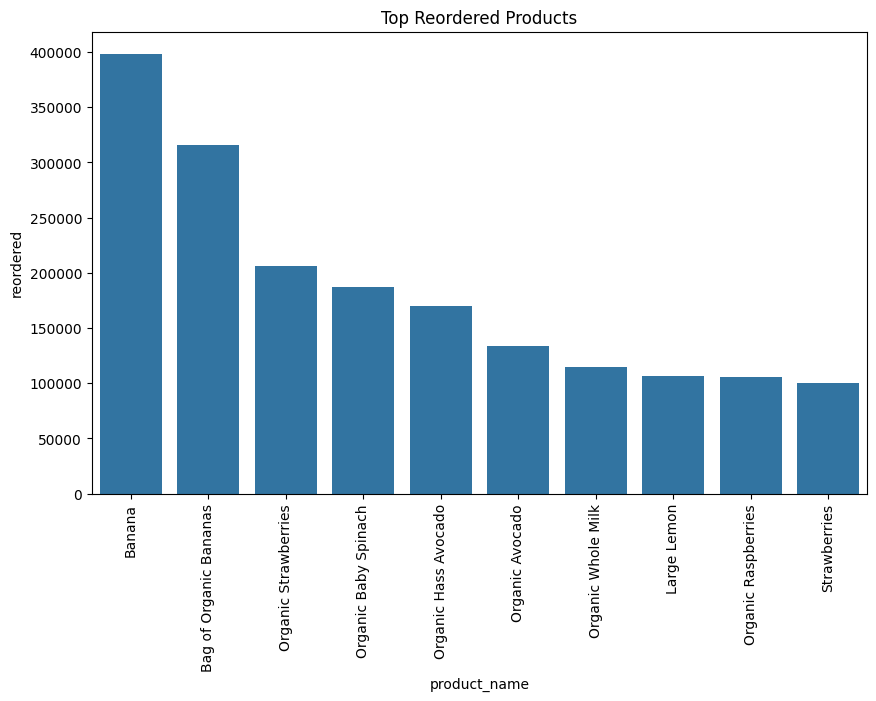

In [7]:
# Plot sales by product
plt.figure(figsize=(10, 6))
sns.barplot(x='product_name', y='reordered', data=top_products)
plt.title('Top Reordered Products')
plt.xticks(rotation=90)
plt.show()
